<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

## Prueba 2.1 Stop words y con 60 epochs

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

import seaborn as sns

### Datos

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 27.2MB/s]


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
# Verifico que no hayan quedado Nans
df_reviews.isnull().values.any()

False

In [7]:
# Reviso las dimensiones
df_reviews.shape

(22641, 2)

In [8]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

df_reviews.Rating.value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


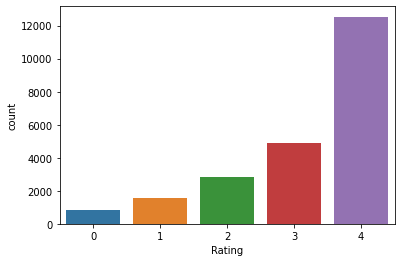

In [9]:
sns.countplot(df_reviews.Rating)
plt.show()


In [10]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [11]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [12]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [14]:
#corpus

In [13]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [14]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [15]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[0:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [16]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

#### Remuevo stop-words

In [17]:
# Para remover las stop-words voy a usar NLTK
import nltk
import string
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords

# Descargar tokenizador punkt
nltk.download("punkt")
# Descargar diccionario de inglés
nltk.download("wordnet")
# Descargar diccionario de stopwords
nltk.download('stopwords')
# Para usar NLTK 3.6.6 o superior es necesario instalar OMW 1.4 
# (Open Multilingual WordNet)
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [18]:
# Stop words
nltk_stop_words = set(stopwords.words("english"))
tokens = [w for w in tokens if w not in nltk_stop_words]
# Quitar los signos de puntuacion
tokens = [w for w in tokens if w not in string.punctuation]
#print("Resultado:", tokens)
len(tokens)

670440

In [19]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [20]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14680

In [21]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)
sequences[0][:10]

[172, 427, 796, 550, 25]

In [22]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

63

In [23]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 63

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [24]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 63)

In [25]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

y = pd.get_dummies(df_reviews.Rating)
print(f'Dimensión de "y": {y.shape}')
y.head()

Dimensión de "y": (22641, 5)


,0,1,2,3,4
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,0,0,1


In [26]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Verifico dimensiones
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22641, 63), (22641, 5), (18112, 63), (18112, 5), (4529, 63), (4529, 5))

In [28]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # multiclass classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 63 , out_shape 5


### 2 - Entrenar el modelo con mis propios Embeddings + LSTM

In [29]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Bidirectional


In [30]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=64))) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 63, 50)            100050    
                                                                 
 bidirectional (Bidirectiona  (None, 63, 128)          58880     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

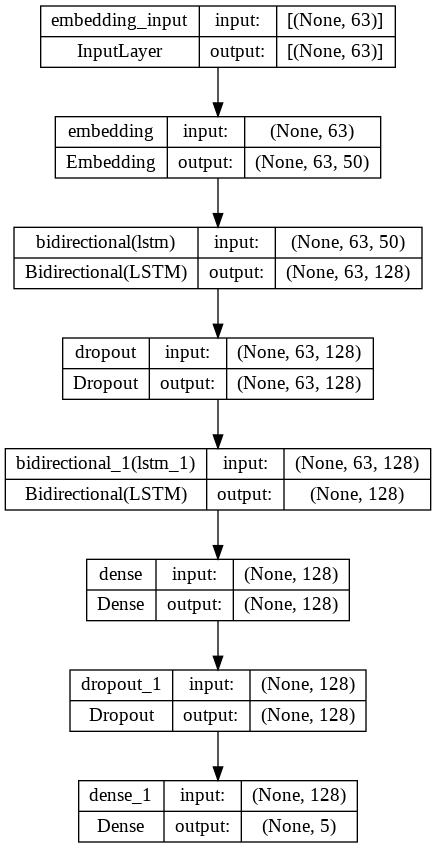

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### 2.1. Con dataset balanceado con Random Oversampling

In [40]:
# Voy a hacer un oversampling con SMOTE para balancear las clases
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(random_state=10, sampling_strategy='auto')
X_resampled, y_resampled = ros.fit_resample(X_train, y_train.to_numpy()) # Paso y_train a numpy array porque daba error

X_resampled.shape, y_resampled.shape

((49975, 63), (49975, 5))

In [41]:
X_ros_train = pd.DataFrame(X_resampled)
y_ros_train = pd.DataFrame(y_resampled)

In [42]:
y_ros_train.head()

,0,1,2,3,4
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,0,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


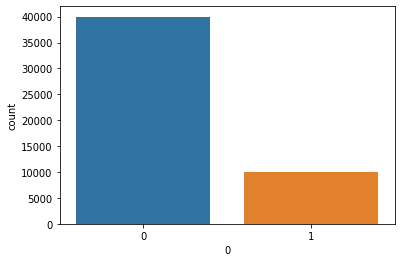

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


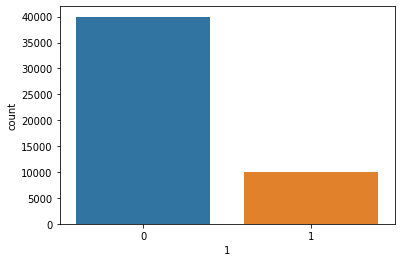

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


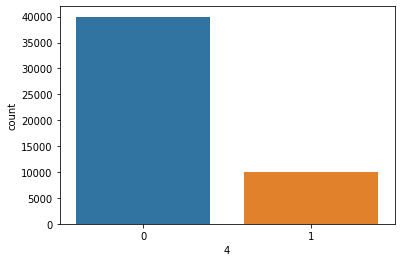

In [43]:
sns.countplot(y_ros_train[0])
plt.show()
sns.countplot(y_ros_train[1])
plt.show()
sns.countplot(y_ros_train[4])
plt.show()

In [44]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=64))) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
hist_ros = model.fit(X_ros_train, y_ros_train, epochs=60, validation_split=0.2)

Epoch 1/60
1250/1250 [==============================] - 28s 18ms/step - loss: 0.8886 - accuracy: 0.6503 - val_loss: 1.5785 - val_accuracy: 0.2238
Epoch 2/60
1250/1250 [==============================] - 21s 17ms/step - loss: 0.5469 - accuracy: 0.7990 - val_loss: 1.3692 - val_accuracy: 0.3107
Epoch 3/60
1250/1250 [==============================] - 21s 17ms/step - loss: 0.4353 - accuracy: 0.8387 - val_loss: 1.2971 - val_accuracy: 0.3079
Epoch 4/60
1250/1250 [==============================] - 23s 19ms/step - loss: 0.3778 - accuracy: 0.8588 - val_loss: 1.1524 - val_accuracy: 0.3939
Epoch 5/60
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3436 - accuracy: 0.8696 - val_loss: 1.1171 - val_accuracy: 0.4306
Epoch 6/60
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3172 - accuracy: 0.8789 - val_loss: 1.0446 - val_accuracy: 0.4747
Epoch 7/60
1250/1250 [==============================] - 22s 17ms/step - loss: 0.2980 - accuracy: 0.8852 - val_loss: 0.9397 -

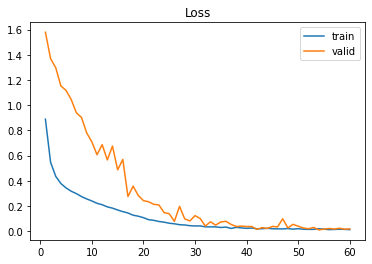

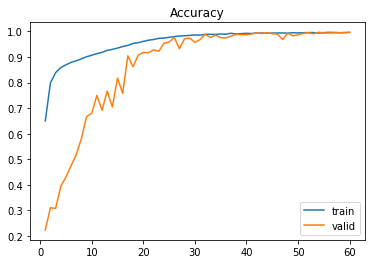

In [43]:
epoch_count = range(1, len(hist_ros.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist_ros.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist_ros.history['val_loss'], label='valid')
plt.title('Loss')
plt.show()
plt.figure()
sns.lineplot(x=epoch_count,  y=hist_ros.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist_ros.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.show()

In [44]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 3s 8ms/step - loss: 4.4938 - accuracy: 0.5668


[4.4937615394592285, 0.5667917728424072]